In [2]:
import sys; sys.path.append('/rds/general/user/cb2714/home/wwa/'); from wwa import *

In [64]:
sf = gpd.read_file("sf_socal-baja/").to_crs(epsg = 4326)
xn, xx, yn, yx = [-125,-110,30,40]
la = [-118.24, 34.05]

mapproj = cartopy.crs.PlateCarree()

states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.to_geodataframe().clip((xn,yn,xx,yx))



days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 1]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 1]

/rds/general/user/cb2714/home/anaconda3/envs/wwa_xesmf/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


# Physical geography

In [65]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(xn,xx), lat = slice(yn,yx))

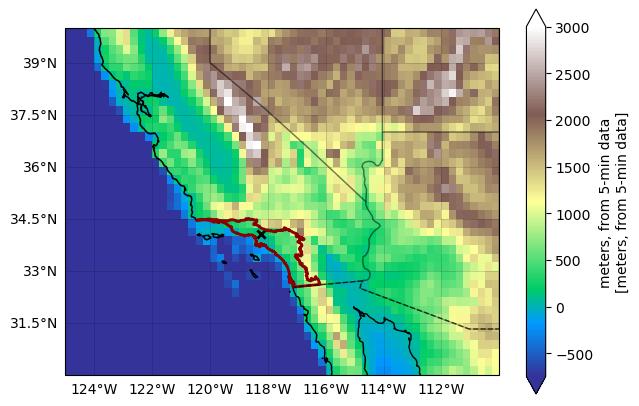

In [67]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : mapproj})

elev.plot(ax = ax, cmap = "terrain", vmin = -750, vmax = 3000)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax.coastlines()

# gacc.boundary.plot(ax = ax, color = "firebrick", lw = 2, ls = "--")
sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
ax.scatter(*la, marker = "x", color = "k", lw = 2)

# Event maps

## FWI (MSWX)

In [146]:
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/mswx/fwi_mswx_2024-2025.nc")

vcols = {"dc" : "Oranges", "dmc" : "Oranges", "ffmc" : "Oranges", "isi" : "Oranges", "bui" : "Oranges", "fwi" : "Oranges"}
vmaxes = {"dc" : 2500, "dmc" : 1500, "ffmc": 100, "isi" : 500, "bui" : 1500, "fwi" : 500}

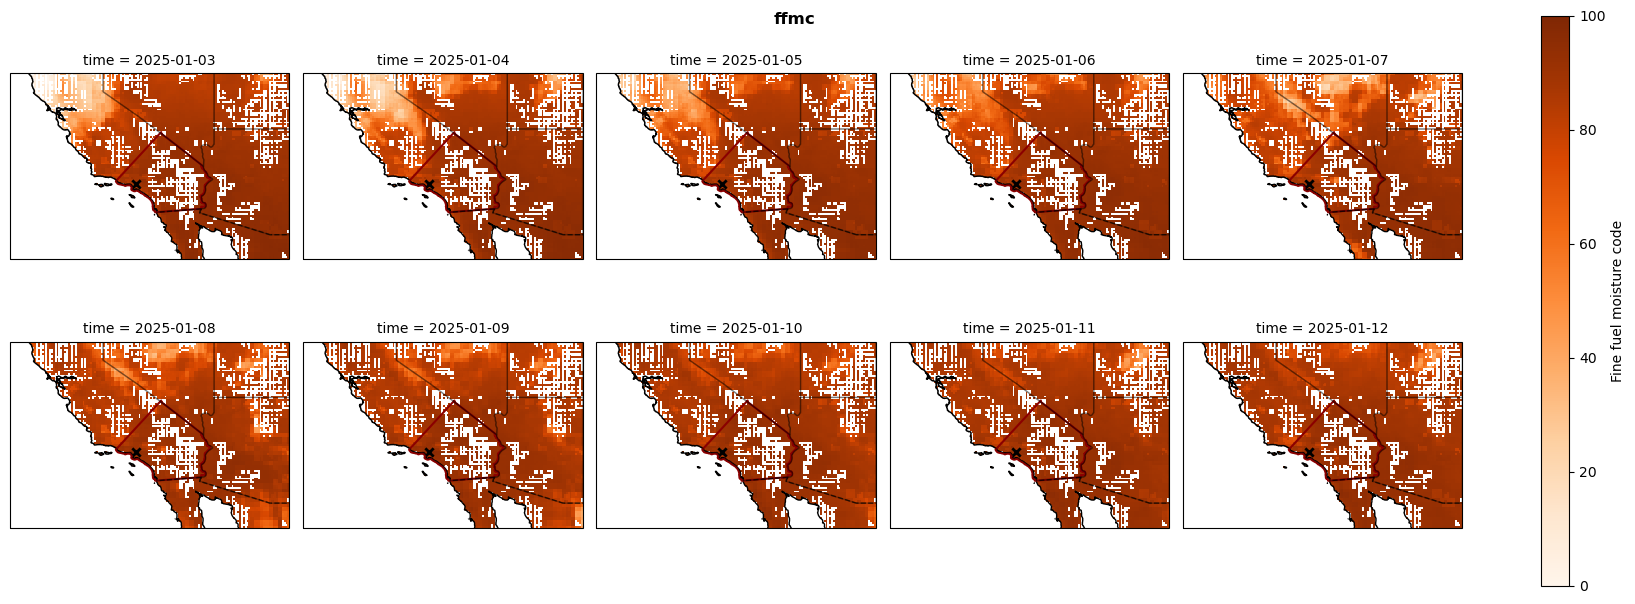

In [147]:
varnm = "ffmc"

fig = da[varnm].sel(time = slice("2025-01-03", None)).plot(col = "time", col_wrap = 5, subplot_kws = {"projection" : mapproj}, cmap = vcols[varnm], vmin = 0, vmax = vmaxes[varnm],
                                        cbar_kwargs = {"fraction" : 0.025}, sharex = True, sharey = True)
plt.suptitle(varnm, fontweight = "bold")

for ax in fig.axs.flat:
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.scatter(*la, marker = "x", color = "k", lw = 2)
    states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    
plt.savefig("/rds/general/user/cb2714/home/wwa/25-01_california-wildfires/fig/event-map_"+varnm+"-2025_mswx.png")

# Rainfall

## Seasonal precip

In [3]:
era5l = xr.open_dataset("data/era5land_precip-pet_monthly_se-cali.nc").tp
era5 = xr.open_dataset("data/era5_precip-pet_monthly_se-cali.nc").tp

Text(0, 0.5, 'Precip (mm)')

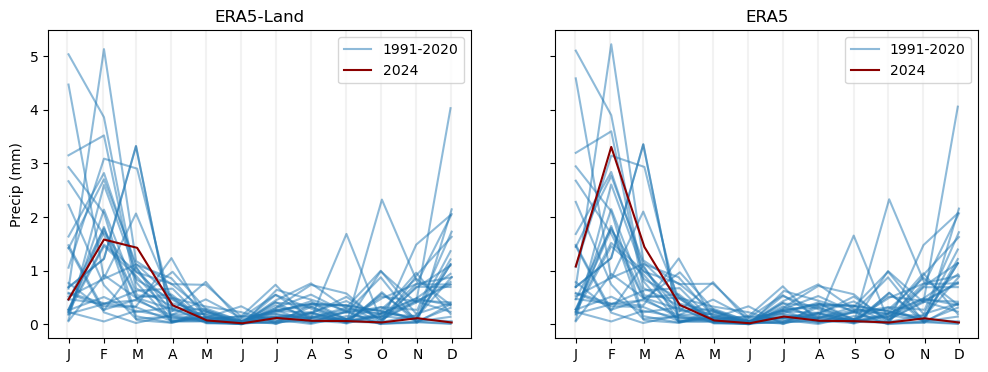

In [35]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharex = True, sharey = True)

for i in range(2):

    ax = axs[i]
    ts = [era5l, era5][i]
    ttl = ["ERA5-Land", "ERA5"][i]
    
    for y in range(1991,2020):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

    y = "1991"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "1991-2020")
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2024")

    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(365) if (days[x].day) == 1]

    ax.set_title(ttl)
    
axs[0].set_ylabel("Precip (mm)")

Text(0, 0.5, 'Precipitation (mm)')

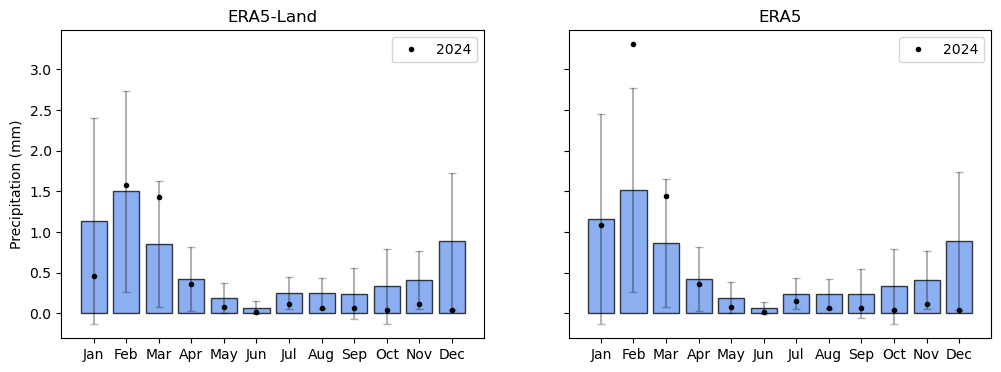

In [31]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)

for i in range(2):

    ax = axs[i]
    ts = [era5l, era5][i]
    ttl = ["ERA5-Land", "ERA5"][i]
    
    mmean = ts.sel(time = slice("1990","2020")).groupby("time.month").mean()
    msd = ts.sel(time = slice("1990","2020")).groupby("time.month").std()
    m_upper = mmean+msd
    m_lower = mmean-msd
    
    ax.bar(mmean.month, mmean, color = "cornflowerblue", edgecolor = "k", alpha = 0.75)
    for m in range(12):
        ax.plot([m+1,m+1], [m_lower.sel(month = m+1), m_upper.sel(month = m+1)], color = "k", alpha = 0.3, marker = "_", solid_capstyle = "butt")
        
    ax.set_xticks(range(13)[1:])
    ax.set_xticklabels(ts.sel(time = "2024").time.dt.strftime("%b").values)
    ax.plot(ts.sel(time = "2024").time.dt.month, ts.sel(time = "2024"), marker = ".", ls = "", color = "k", label = "2024")
    ax.legend()
    ax.set_title(ttl)
        
axs[0].set_ylabel("Precipitation (mm)")

## OND precip

In [82]:
era5l_ond = era5l.sel(time = era5l.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").sum()
era5_ond = era5.sel(time = era5.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").sum()

era5l_ndj = era5l.sel(time = era5l.time.dt.month.isin([11,12,1])).resample(time = "AS-OCT").mean()
era5l_ndj[-1] = np.nan
era5_ndj = era5.sel(time = era5.time.dt.month.isin([11,12,1])).resample(time = "AS-OCT").mean()
era5_ndj[-1] = np.nan

In [83]:
era5l_ond.assign_coords(time = era5l_ond.time.dt.year+1).rename(time = "year").to_pandas().to_csv("ts/era5-land_pr-ond.csv")
era5_ond.assign_coords(time = era5_ond.time.dt.year+1).rename(time = "year").to_pandas().to_csv("ts/era5_pr-ond.csv")

era5l_ndj.assign_coords(time = era5l_ndj.time.dt.year+1).rename(time = "year").to_pandas().to_csv("ts/era5-land_pr-ndj.csv")
era5_ndj.assign_coords(time = era5_ndj.time.dt.year+1).rename(time = "year").to_pandas().to_csv("ts/era5_pr-ndj.csv")

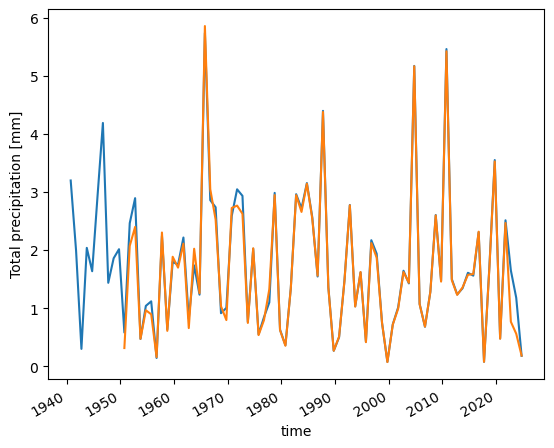

In [84]:
era5_ond.plot()
era5l_ond.plot()

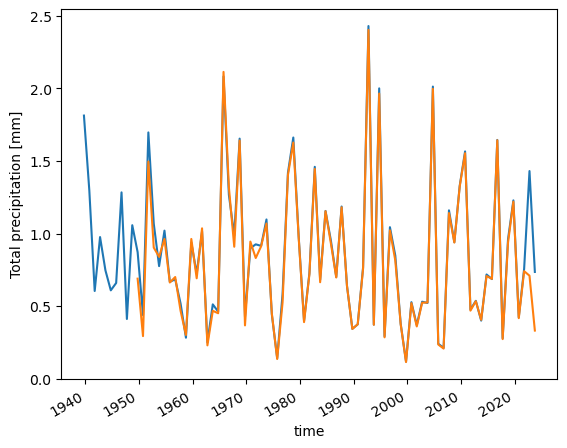

In [65]:
era5_ndj.plot()
era5l_ndj.plot()

## Seasonal Nino indices

In [ ]:
nino34_ond = nino34_det.sel(time = nino34_det.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean()
nino34_ndj = nino34_det.sel(time = nino34_det.time.dt.month.isin([11,12,1])).resample(time = "AS-OCT").mean()
nino34_nd = nino34_det.sel(time = nino34_det.time.dt.month.isin([11,12])).resample(time = "AS-OCT").mean()

In [126]:
nino34_ond.assign_coords(time = nino34_ond.time.dt.year + 1).rename(time = "year").to_pandas().to_csv("ts/nino_ond.csv")
nino34_ndj.assign_coords(time = nino34_ndj.time.dt.year + 1).rename(time = "year").to_pandas().to_csv("ts/nino_ndj.csv")
nino34_nd.assign_coords(time = nino34_nd.time.dt.year + 1).rename(time = "year").to_pandas().to_csv("ts/nino_nd.csv")

Text(0.5, 1.0, 'Comparison of seasonal Nino indices')

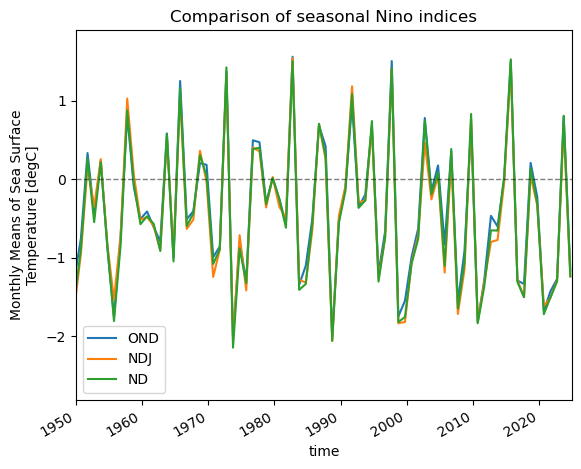

In [130]:
nino34_ond.plot(label = "OND")
nino34_ndj.plot(label = "NDJ")
nino34_nd.plot(label = "ND")


ax = plt.gca()
ax.axhline(0, ls = "--", alpha = 0.5, lw = 1, color = "k")
ax.legend()
ax.set_xlim(datetime(1950,1,1),datetime(2025,1,1))
ax.set_title("Comparison of seasonal Nino3.4 indices")

In [95]:
emi = pd.read_csv("data/nino-modoki.csv", index_col = "time", parse_dates = ["time"]).to_xarray().sst

In [106]:
def scale(ts): return (ts - ts.mean()) / ts.std()

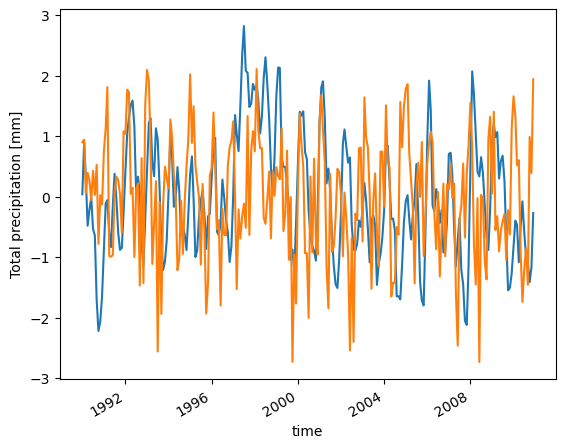

In [110]:
scale(-emi.sel(time = slice("1990","2010"))).plot()
scale(np.log(era5.sel(time = slice("1990","2010")))).plot()

In [96]:
emi_ond = emi.sel(time = emi.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").mean()
emi_ndj = emi.sel(time = emi.time.dt.month.isin([11,12,1])).resample(time = "AS-OCT").mean()
emi_nd = emi.sel(time = emi.time.dt.month.isin([11,12])).resample(time = "AS-OCT").mean()

In [97]:
emi_ond.assign_coords(time = emi_ond.time.dt.year + 1).rename(time = "year").to_pandas().to_csv("ts/modoki_ond.csv")
emi_ndj.assign_coords(time = emi_ndj.time.dt.year + 1).rename(time = "year").to_pandas().to_csv("ts/modoki_ndj.csv")
emi_nd.assign_coords(time = emi_nd.time.dt.year + 1).rename(time = "year").to_pandas().to_csv("ts/modoki_nd.csv")

Text(0.5, 1.0, 'Comparison of seasonal Enso Modoki indices')

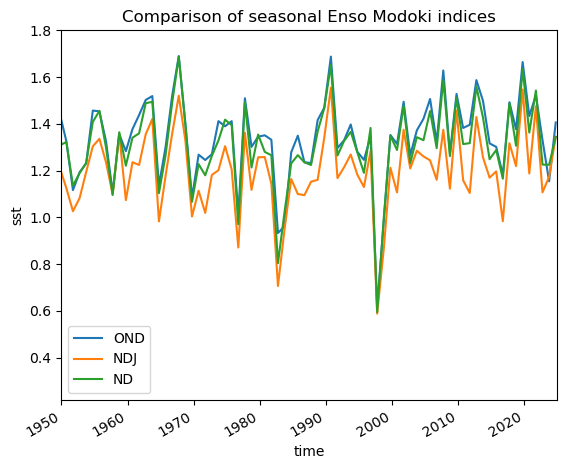

In [98]:
emi_ond.plot(label = "OND")
emi_ndj.plot(label = "NDJ")
emi_nd.plot(label = "ND")

ax = plt.gca()
# ax.axhline(0, ls = "--", alpha = 0.5, lw = 1, color = "k")
ax.legend()
ax.set_xlim(datetime(1950,1,1),datetime(2025,1,1))
ax.set_title("Comparison of seasonal Enso Modoki indices")

In [72]:
era5_ndj

<xarray.DataArray 'tp' (time: 85)>
array([1.812796  , 1.2961121 , 0.6047285 , 0.97613436, 0.7472205 ,
       0.6092238 , 0.6599537 , 1.2839044 , 0.41197774, 1.0578021 ,
       0.87213606, 0.43849048, 1.696735  , 1.0695114 , 0.77604014,
       1.0203724 , 0.66768545, 0.6853931 , 0.5186231 , 0.28300005,
       0.9380417 , 0.7247079 , 1.015684  , 0.25046173, 0.5125912 ,
       0.46307996, 2.0817335 , 1.2668405 , 0.986743  , 1.6540483 ,
       0.42738187, 0.8991823 , 0.9261423 , 0.91562   , 1.0973035 ,
       0.44414547, 0.14143454, 0.5838148 , 1.4186312 , 1.6616521 ,
       0.98096514, 0.3989202 , 0.7273292 , 1.45985   , 0.681155  ,
       1.1559012 , 0.95286757, 0.70112795, 1.18639   , 0.64006084,
       0.34394574, 0.3751646 , 0.76808643, 2.429328  , 0.3731295 ,
       2.0000932 , 0.29277644, 1.044144  , 0.8484635 , 0.37963906,
       0.11905914, 0.5276933 , 0.3697317 , 0.5310129 , 0.52227646,
       2.0124893 , 0.24157353, 0.21292019, 1.1601633 , 0.9407223 ,
       1.3291122 , 1.5659748 , 0.47670937, 0.53694737, 0.4006199 ,
       0.7183755 , 0.6869714 , 1.6450003 , 0.27907357, 0.96085805,
       1.2287958 , 0.42318538, 0.7569043 , 1.4307508 , 0.7359522 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1939-10-01 1940-10-01 ... 2023-10-01
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      2501
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    mm
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [123]:
dsr = pd.read_csv("data/daily_dsr_mean_era5.csv", index_col = "time", parse_dates = ["time"]).rename(columns = {"0" : "dsr"})
hdwi = pd.read_csv("data/daily_hdwi_mean_era5-land.csv", index_col = "time", parse_dates = ["time"]).rename(columns = {"0" : "hdwi"})

In [136]:
jan_hdwi = hdwi.loc[hdwi.index.month.isin([1])].resample("AS").mean()

In [137]:
max_jan_hdwi = hdwi.loc[hdwi.index.month.isin([1])].resample("AS").max()

In [140]:
max_jan_hdwi.index = range(1970, 2025)

In [142]:
max_jan_hdwi.to_csv("ts/era5-land_hdwi-janmax.csv")

In [145]:
hdwi_mean = hdwi.resample("M").mean()

In [153]:
mean_jan_hdwi = hdwi_mean.loc[hdwi_mean.index.month == 1]
mean_jan_hdwi.index = range(1970, 2025)
mean_jan_hdwi.to_csv("ts/era5-land_hdwi-janmean.csv")